In [1]:
# !pip install seaborn 1> /dev/null # 1> means redirect stdout

# Import

In [2]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score, classification_report, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, Normalizer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
pd.set_option('display.max_rows', 500)
random_state = 42
data_filepath = './data/'
# data_filepath = '/kaggle/input/child-mind-institute-problematic-internet-use/'

# Data

In [3]:
!du -hs $data_filepath*
train_df = pd.read_csv(data_filepath + 'train.csv')
test_df = pd.read_csv(data_filepath + 'test.csv')
train_df.shape, test_df.shape

6.2G	./data/child-mind-institute-problematic-internet-use.zip
 12K	./data/data_dictionary.csv
4.0K	./data/sample_submission.csv
7.9M	./data/series_test.parquet
6.3G	./data/series_train.parquet
8.0K	./data/test.csv
924K	./data/train.csv


((3960, 82), (20, 59))

In [4]:
train_df.sii.value_counts(dropna=False)

sii
0.0    1594
NaN    1224
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

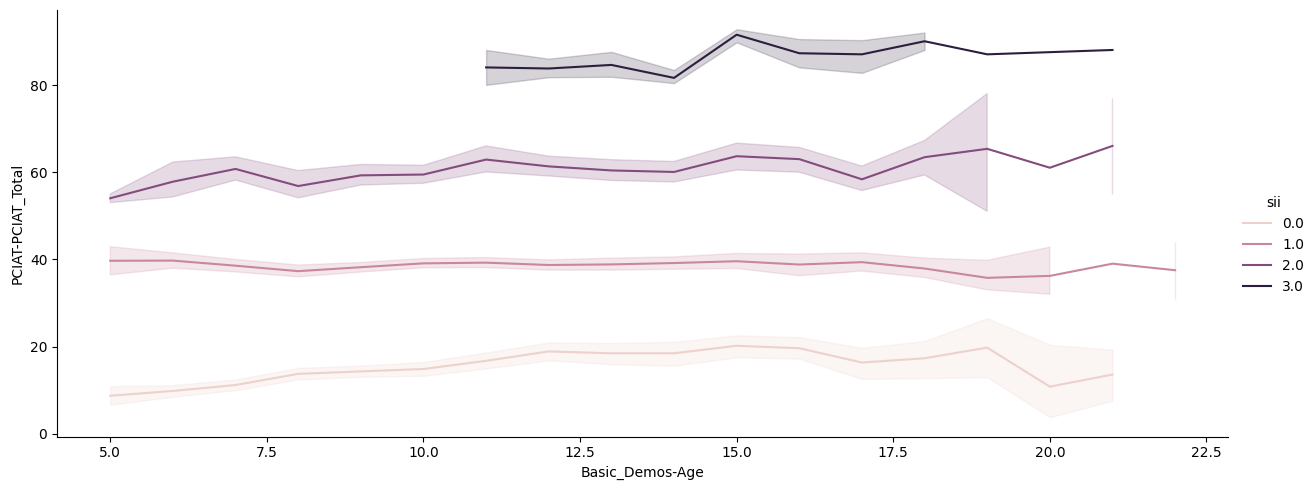

In [5]:
sns.relplot(train_df, x='Basic_Demos-Age', y='PCIAT-PCIAT_Total', hue='sii', kind='line', aspect=2.5)

# Fill missing

In [6]:
cols_to_drop = ['sii', 'id']
X, y = train_df.drop(columns=cols_to_drop), train_df.sii
X.shape, y.shape

((3960, 80), (3960,))

In [7]:
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

In [8]:
numeric_transormer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # ('imputer', SimpleImputer(strategy='constant', fill_value=-999)),
])  
category_transormer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OrdinalEncoder()),
])
cols_transformer = ColumnTransformer(transformers=[
    ('numeric', numeric_transormer, num_cols),
    ('category', category_transormer, cat_cols),
])
preproc_df_pipe = Pipeline(steps=[
    ('cols_transformer', cols_transformer),
    ('scaler', StandardScaler()),
    ('nomralize', Normalizer(norm='l2')),
])
preproc_df_pipe

Pipeline(steps=[('cols_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Basic_Demos-Age',
                                                   'Basic_Demos-Sex',
                                                   'CGAS-CGAS_Score',
                                                   'Physical-BMI',
                                                   'Physical-Height',
                                                   'Physical-Weight',
                                                   'Physical-Waist_Circumference',
                                                   'Physical-Diastolic_BP',
                                                   'Physical-HeartRate',
                                                   'Physical-Systolic_BP',
                                                   'Fi...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Basic_Demos-Enroll_Season',
                                                   'CGAS-Season',
                                                   'Physical-Season',
                                                   'Fitness_Endurance-Season',
                                                   'FGC-Season', 'BIA-Season',
                                                   'PAQ_A-Season',
                                                   'PAQ_C-Season',
                                                   'PCIAT-Season', 'SDS-Season',
                                                   'PreInt_EduHx-Season'])])),
                ('scaler', StandardScaler()), ('nomralize', Normalizer())])

In [9]:
X = pd.DataFrame(preproc_df_pipe.fit_transform(X), columns=X.columns)
X

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,-0.143371,-0.072698,-0.077091,-0.044464,-0.140099,-0.084682,-0.010115,-0.009851,-0.003567,-0.014189,...,0.178608,-0.129869,-0.020818,-0.131668,-0.189497,0.026486,-0.029988,-0.132960,-0.033817,-0.129512
1,-0.045555,-0.087550,-0.001808,-0.125179,-0.134019,-0.115752,-0.180243,0.055651,-0.109911,0.044345,...,-0.036724,-0.156402,-0.025072,-0.158569,0.178321,0.031897,-0.182497,-0.160125,-0.162906,0.058304
2,-0.015554,0.166336,0.042003,-0.066957,0.015208,-0.034817,-0.013752,-0.046058,0.136059,0.006716,...,-0.183603,-0.176565,-0.216049,-0.179012,0.048328,0.036010,0.124483,-0.180769,-0.183908,0.065820
3,-0.047401,-0.091099,0.038715,-0.018604,0.004989,-0.014182,-0.012675,-0.092631,0.155377,0.006191,...,-0.169228,0.068536,0.146957,0.071181,0.044544,0.033190,0.267051,0.084831,0.084754,0.172147
4,0.430380,0.263738,-0.003236,-0.048007,-0.022477,-0.048016,-0.021804,-0.021236,-0.007690,-0.030588,...,0.159645,-0.081028,-0.044878,-0.080693,0.076628,-0.287043,-0.064645,-0.070345,-0.072900,-0.087413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,0.090870,-0.097553,-0.038241,-0.074127,0.073013,-0.012629,-0.013573,0.019021,-0.122469,-0.104606,...,-0.040920,-0.174271,-0.027936,-0.176685,-0.254287,0.035542,0.285972,0.225473,0.226897,-0.173793
3956,-0.017480,-0.111076,-0.002294,-0.007579,-0.048953,-0.036217,0.037851,-0.112945,-0.041995,0.017291,...,-0.046593,-0.057431,-0.031809,-0.057194,-0.117612,0.040468,0.325614,-0.049859,-0.051670,0.209898
3957,0.018974,-0.092294,0.018658,0.064832,0.078223,0.070910,-0.012841,0.099336,0.177659,-0.001823,...,-0.038714,0.186591,-0.026430,0.191753,0.187982,0.033626,0.270556,0.213318,0.214666,-0.164424
3958,0.120864,-0.129753,0.045505,-0.252751,0.385132,0.002758,-0.018053,-0.146230,-0.290959,-0.036706,...,-0.054427,0.262322,-0.037157,-0.066811,0.063445,0.047273,-0.053524,-0.058243,-0.060358,-0.072375


# TSNE

In [10]:
%%time
train_tsne = TSNE(n_components=2).fit_transform(X)
train_tsne = pd.DataFrame(train_tsne, columns=['tsne1', 'tsne2'])
train_tsne['sii'] = y.fillna('missing')
train_tsne

CPU times: user 51.2 s, sys: 23.8 s, total: 1min 15s
Wall time: 8.51 s


,tsne1,tsne2,sii
0,17.888145,-18.604830,2.0
1,-26.058954,-38.434677,0.0
2,2.615494,-39.324940,0.0
3,26.682375,-21.229137,1.0
4,44.935032,32.121387,missing
...,...,...,...
3955,-11.535548,2.209181,1.0
3956,7.962877,-49.845692,missing
3957,5.320070,-1.582648,1.0
3958,-32.108261,39.819496,0.0


<Axes: xlabel='tsne1', ylabel='tsne2'>

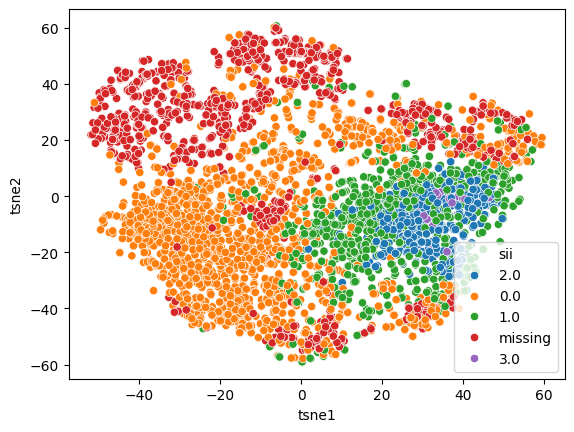

In [11]:
sns.scatterplot(data=train_tsne, x='tsne1', y='tsne2', hue='sii')

# PCA

In [12]:
%%time
train_pca = PCA(n_components=2).fit_transform(X)
train_pca = pd.DataFrame(train_pca, columns=['pca1', 'pca2'])
train_pca['sii'] = y.fillna('missing')
train_pca

CPU times: user 95 ms, sys: 49.6 ms, total: 145 ms
Wall time: 19.5 ms


,pca1,pca2,sii
0,0.487386,0.176518,2.0
1,-0.568260,-0.161423,0.0
2,0.138852,-0.057828,0.0
3,0.527702,-0.220193,1.0
4,-0.114620,0.255638,missing
...,...,...,...
3955,0.287861,-0.119635,1.0
3956,0.041659,-0.265654,missing
3957,0.286428,-0.117890,1.0
3958,-0.184980,0.087490,0.0


<Axes: xlabel='pca1', ylabel='pca2'>

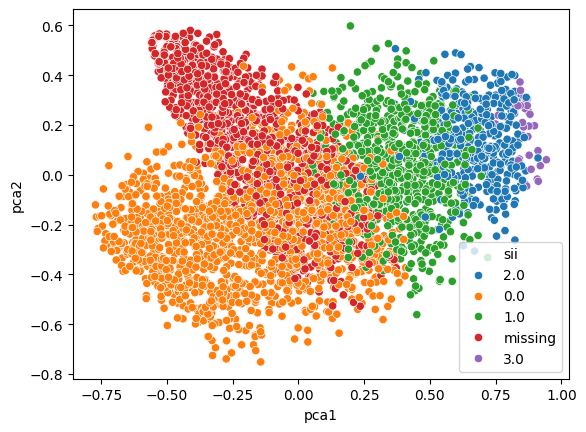

In [13]:
sns.scatterplot(data=train_pca, x='pca1', y='pca2', hue='sii')

# MiniBatchKMeans

In [14]:
%%time
train_pca = PCA(n_components=2).fit_transform(X)
train_pca = pd.DataFrame(train_pca, columns=['pca1', 'pca2'])

CPU times: user 83.7 ms, sys: 15.4 ms, total: 99.1 ms
Wall time: 15.2 ms


In [15]:
wcss = list()
silhouette = list()
for i in range(3, 10):
    cluster = MiniBatchKMeans(n_clusters=i, random_state=random_state)
    labels = cluster.fit_predict(train_pca)
    silhouette.append(silhouette_score(X, labels))
    wcss.append(cluster.inertia_)

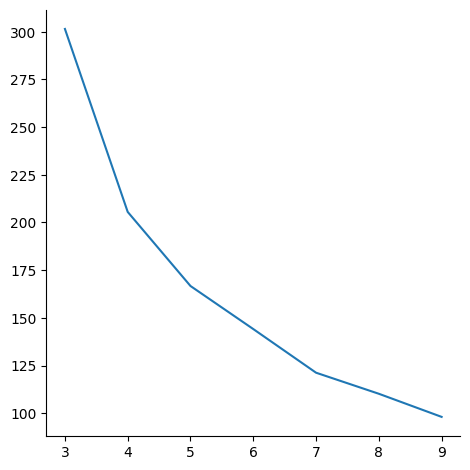

In [16]:
sns.relplot(x=range(3,10), y=wcss, kind='line')

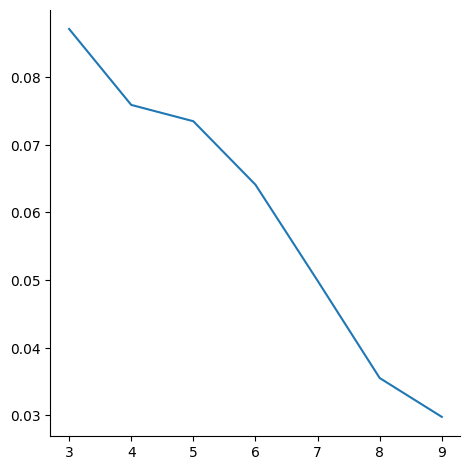

In [17]:
sns.relplot(x=range(3,10), y=silhouette, kind='line')